# How Elon Musk's tweets affect stock prices?


# Application setup
First of all, let's setup authentication to Twitter API.


In [52]:
import numpy
import tweepy
import pandas
import SECRETS
import re
import matplotlib.pyplot as plt

# Authenticate to Twitter
auth = tweepy.OAuthHandler(SECRETS.API_KEY, SECRETS.API_SECRET_KEY)
auth.set_access_token(SECRETS.ACCESS_TOKEN, SECRETS.ACCESS_SECRET_TOKEN)

api = tweepy.API(auth)

try:
    api.verify_credentials()
    print('Authentication OK')
except:
    print('Error during authentication')


Authentication OK



Everything seems fine, we can proceed to download data.

5 latest tweets:


In [53]:

musk_tweets = api.user_timeline(screen_name='elonmusk',
                                count=5,
                                tweet_mode='extended'
                                )

for tweet in musk_tweets:
     print('------------')
     print("ID: {}".format(tweet.id))
     print(tweet.created_at)
     print(tweet.full_text)


------------
ID: 1386759755088211974
2021-04-26 19:11:05
@PPathole An advantage I did have is that my father is a talented electrical &amp; mechanical engineer, so I was taught a lot engineering (without appreciating it at the time)
------------
ID: 1386744515856322563
2021-04-26 18:10:31
@PPathole True. The opposite in fact – I provide financial support to my parents.
------------
ID: 1386743561585102853
2021-04-26 18:06:44
RT @Space_Station: The @SpaceX Crew-1 astronauts will soon soar back to Earth and parachute to a splashdown off the coast of Florida. They…
------------
ID: 1386563667706011653
2021-04-26 06:11:54
@BLKMDL3 @JohnnaCrider1 We just got approval to open a new Supercharger station in Malibu!
------------
ID: 1386562909833109505
2021-04-26 06:08:53
@JohnnaCrider1 https://t.co/xl441YNnOs



# Downloading tweets

It is worth mentioning here that the maximum allowed .user_timeline(count=) is 200.


In [54]:

downloaded_tweets = []
last_id = musk_tweets[-1].id

while True:
    musk_tweets = api.user_timeline(screen_name='elonmusk',
                               count=200,
                               include_rts = False,
                               max_id = last_id - 1,
                               tweet_mode = 'extended'
                               )
    downloaded_tweets.extend(musk_tweets)
    if len(musk_tweets) == 0:
        break
    last_id = musk_tweets[-1].id
    downloaded_tweets.extend(musk_tweets)
    print('N of tweets downloaded till now {}'.format(len(downloaded_tweets)))

print(len(downloaded_tweets))


N of tweets downloaded till now 378
N of tweets downloaded till now 768
N of tweets downloaded till now 1146
N of tweets downloaded till now 1524
N of tweets downloaded till now 1916
N of tweets downloaded till now 2278
N of tweets downloaded till now 2628
2628



# Analysing data. First conclusions


In [55]:

words_in_tweets = {}

for tweet in downloaded_tweets:

    # using regular expression to be exclude all "@#!.?"
    t_words = re.findall(r'\w+', tweet.full_text)

    # adding words counting
    for word in t_words:
        if word in words_in_tweets:
            words_in_tweets[word] += 1
        else:
            words_in_tweets[word] = 1

print(words_in_tweets)
words_to_work_with = words_in_tweets.copy()


{'BadAstronomer': 2, 'So': 14, 'awesome': 12, 'Let': 10, 's': 194, 'find': 2, 'out': 68, 'just': 78, 'how': 22, 'live': 2, 'Saturday': 2, 'Night': 2, 'Live': 4, 'really': 20, 'is': 724, 'Am': 10, 'hosting': 2, 'SNL': 2, 'on': 202, 'May': 6, '8': 16, 'Tesmanian_com': 26, 'Yup': 30, 'KuroiKumanoashi': 2, 'Lies': 2, 'can': 84, 'be': 286, 'beautiful': 6, 'https': 306, 't': 442, 'co': 306, 'l6Bc0wkWol': 2, 'define': 2, 'beauty': 2, 'What': 26, 'does': 16, 'the': 644, 'future': 26, 'hodl': 2, 'OwenSparks_': 28, 'PPathole': 130, 'Absolutely': 28, 'This': 114, 'essence': 2, 'of': 524, 'my': 54, 'philosophy': 2, 'SciGuySpace': 28, 'important': 34, 'lexfridman': 48, '2': 46, 'mins': 12, 'to': 736, 'launch': 44, 'q9nXKRrXpw': 2, 'Astronauts': 4, 'preparing': 2, 'Space_Station': 22, 'WBkaDZexEc': 2, 'JiriThunderDome': 2, 'Yeah': 50, 'ICannot_Enough': 18, 'Haha': 32, 'true': 36, 'Happy': 10, 'Earth': 44, 'Day': 6, 'hnshah': 2, 'jhall': 2, 'AstroJordy': 30, 'I': 224, 'm': 22, 'staying': 2, 'at': 144


We have dictionary {'word' : times_used} <br/>
Let's plot some words


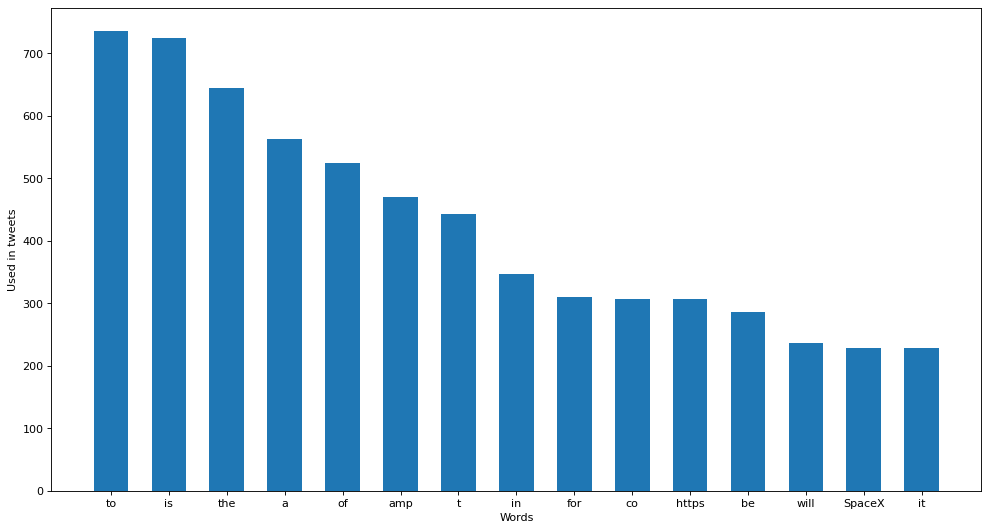

In [56]:

# we don't want to print all words yet, so let's have a look at 30 of them first
df = pandas.DataFrame(words_in_tweets.items(), columns=['word', 'used'])
df.sort_values('used',ascending=False, inplace=True)


fig = plt.figure(figsize=(15, 8), dpi=80)
ax = fig.add_subplot(111)
ax.bar('word', 'used', data=df.iloc[:15], width=0.6)
ax.set_ylabel('Used in tweets')
ax.set_xlabel('Words')
plt.show()



# Improving data quality

 We need to improve quality of our data. Let's delete some unimportant words like "the" "a" "is" etc,
 then print once again <br/>

1) It is also a good idea to save words_in_tweets to pandas.dataFrame.<br/>
2) We need to use the field *.created_at* in every tweet we are interested in (*downloaded_tweets*).


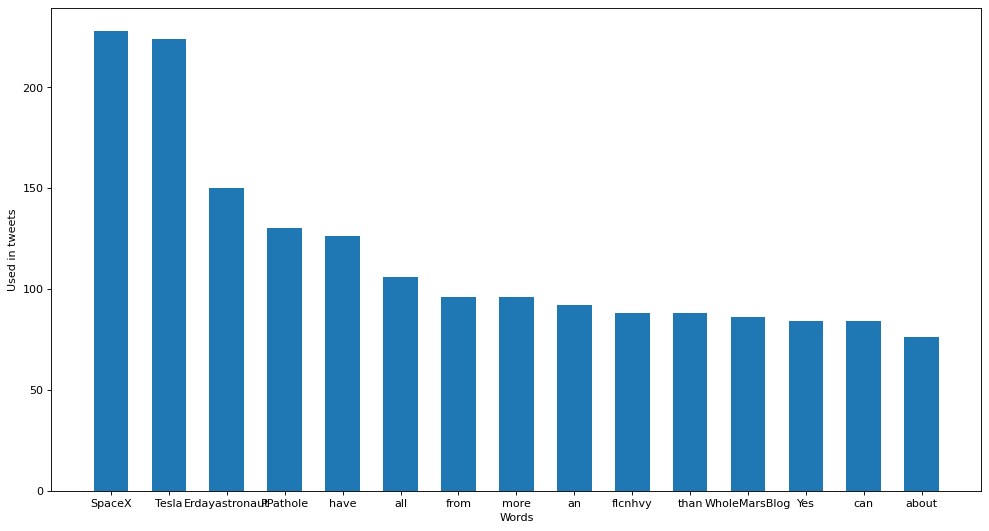

In [57]:

unimportant_words = ['the' ,'a', 'to', 'is', 't', 'of',
                     'be', 'will', 'that', 'this', 'https',
                     'co', 'on', 'we', 'with', 'so', 'for',
                     'at', 'but', 's', 'you', 'was', 'in',
                     'it', 'I', 'or', 'year', 'as', 'are',
                     'no', 'not', 'with', 'This', 'It', 'much',
                     'We', 'do', 'by', 'just', 'The', 'amp'
                     ]
for word in unimportant_words:
    words_to_work_with.pop(word, None)

df = pandas.DataFrame(words_to_work_with.items(), columns=['word', 'used'])
df.sort_values('used',ascending=False, inplace=True)


fig = plt.figure(figsize=(15, 8), dpi=80)
ax = fig.add_subplot(111)
ax.bar('word', 'used', data=df.iloc[:15], width=0.6)
ax.set_ylabel('Used in tweets')
ax.set_xlabel('Words')
plt.show()


In [58]:

# saving our dictionary to DataFrame
words_in_tweets_df = pandas.DataFrame(words_in_tweets.items(), columns=['word', 'used'])

print(words_in_tweets_df.head(15))

# saving downloaded_tweets into a pandas.DataFrame
# firstly, we need to create list  which will help us putting interesting data in df

temp_list_of_dicts = []
for tweet in downloaded_tweets:
    temp_list_of_dicts.append({'id': tweet.id, 'text': tweet.full_text, 'date': tweet.created_at})

# FILTERING DATA
downloaded_tweets_df = pandas.DataFrame(temp_list_of_dicts)
downloaded_tweets_df['text'] = downloaded_tweets_df['text'].str.lower()

df_tesla_word = downloaded_tweets_df[downloaded_tweets_df['text'].str.contains('tesla', na=False)]
df_spacex_word = downloaded_tweets_df[downloaded_tweets_df['text'].str.contains('spacex', na=False)]

# we have tweets with words tesla or spacex
print(df_tesla_word.shape)
print(df_spacex_word.shape)


             word  used
0   BadAstronomer     2
1              So    14
2         awesome    12
3             Let    10
4               s   194
5            find     2
6             out    68
7            just    78
8             how    22
9            live     2
10       Saturday     2
11          Night     2
12           Live     4
13         really    20
14             is   724
(346, 3)
(232, 3)



# Downloading historical data of tesla and spacex stock prices
Let's check the oldest tweet and download stock data from this day.


In [59]:

# extracting date to string
oldest_tweet_about_tesla_date = str(df_tesla_word.date.iloc[-1])
oldest_tweet_about_spacex_date = str(df_spacex_word.date.iloc[-1])

oldest_tweet_about_tesla_date = oldest_tweet_about_tesla_date.split(' ')
oldest_tweet_about_spacex_date = oldest_tweet_about_spacex_date.split(' ')

oldest_tweet_about_tesla_date = oldest_tweet_about_tesla_date[0]
oldest_tweet_about_spacex_date = oldest_tweet_about_spacex_date[0]

oldest_tweet_about_tesla_date = oldest_tweet_about_tesla_date.split('-')
oldest_tweet_about_spacex_date = oldest_tweet_about_spacex_date.split('-')

# YEAR MONTH DAY
date_tesla = [int(a) for a in oldest_tweet_about_tesla_date]
date_spacex = [int(a) for a in oldest_tweet_about_spacex_date]


In [60]:
# importing important libraries
from datetime import datetime
import yfinance as yahoofinance

In [61]:

# downloading dataframe from Yahoo Finance
start_date = datetime(date_tesla[0], date_tesla[1], date_tesla[2])
end_date = datetime.now()
tesla_stock_prices_data = yahoofinance.download('TSLA', start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed



# Adjusting and merging Dataframes


In [125]:

temp_DF = df_tesla_word.copy()
temp_DF.reset_index(inplace=True)
tweets_dates_list = []

temp_DF = temp_DF.drop(columns=['index', 'id', 'text'])
for row in temp_DF.date:
    tweets_dates_list.append(str(row).split(' ')[0])

# adjusting dataframe and cleaning data
tweets_dates_DF = pandas.DataFrame(data=tweets_dates_list)
tweets_dates_DF.drop_duplicates(inplace=True)
tweets_dates_DF =  tweets_dates_DF[::-1]
tweets_dates_DF.reset_index(inplace=True)
tweets_dates_DF = tweets_dates_DF.drop(columns=['index'])
tweets_dates_DF.columns = ['Date']

prices_data = tesla_stock_prices_data.copy()
prices_data.reset_index(inplace=True)
# changing TimeStamp to str (because tweets_dates_DF.Date is str)
prices_data['Date']= prices_data['Date'].astype(str)

# merging data to print relevant markers in specific dates, dropping useless columns
inner_merged = pandas.merge(tweets_dates_DF, prices_data)
inner_merged = inner_merged.drop(columns=['Open', 'Low', 'Close',
                                          'Adj Close', 'Volume'])
prices_data = prices_data.drop(columns=['Open', 'Low', 'Close',
                                          'Adj Close', 'Volume'])

print(inner_merged.head())
print(prices_data.head())


         Date        High
0  2020-11-03  427.769989
1  2020-11-05  440.000000
2  2020-11-06  436.570007
3  2020-11-09  452.500000
4  2020-11-10  420.089996
         Date        High
0  2020-11-02  406.980011
1  2020-11-03  427.769989
2  2020-11-04  435.399994
3  2020-11-05  440.000000
4  2020-11-06  436.570007



# Plotting stock prices with tweet days markers


<ipython-input-156-ba524508c6f4>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  stock_price.set_xticklabels(prices_data.Date)
<ipython-input-156-ba524508c6f4>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  musk_twitter_act = stock_fig.add_subplot(111)


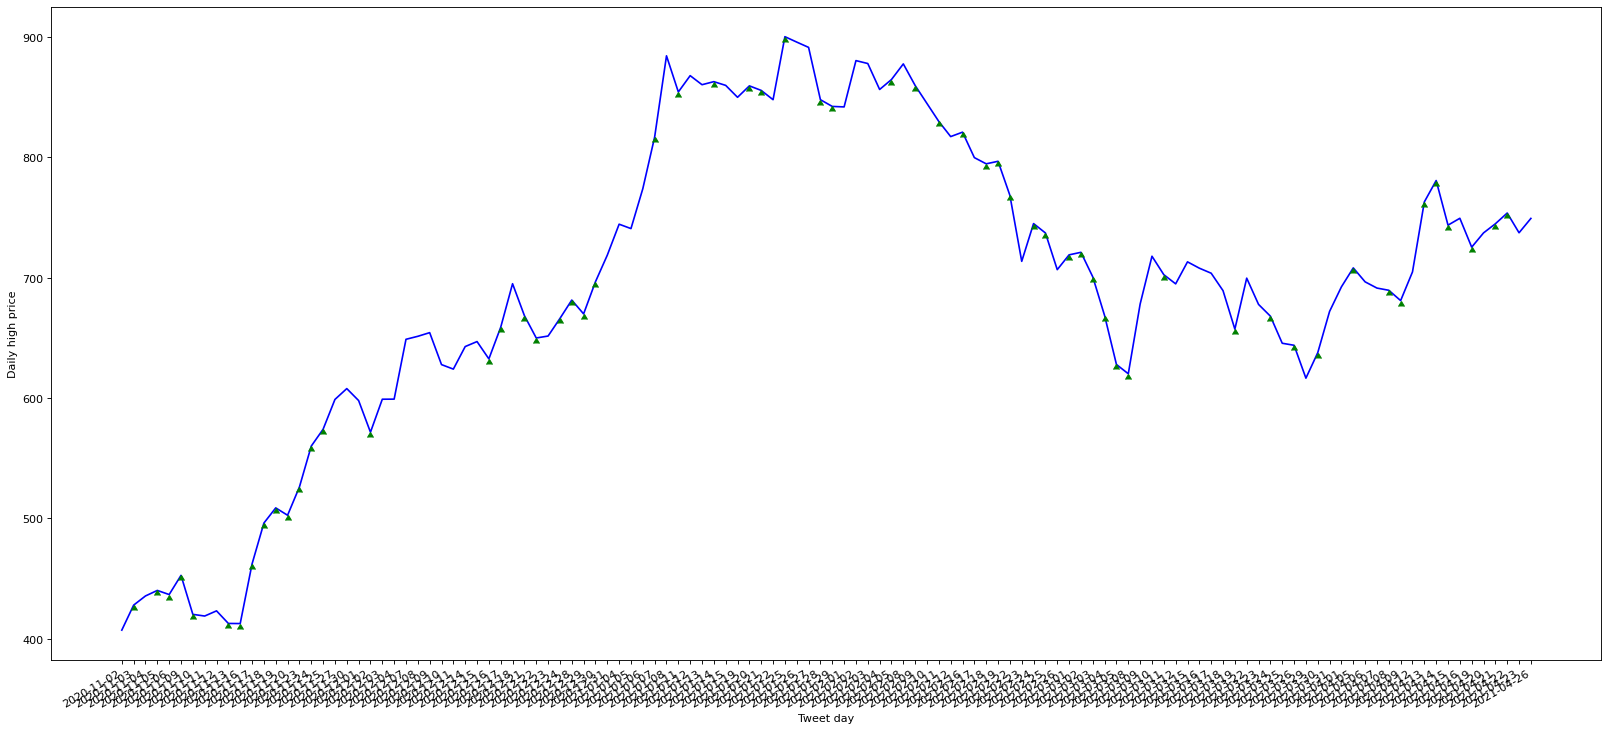

In [156]:

stock_fig = plt.figure(figsize=(25, 12), dpi=80)


stock_price = stock_fig.add_subplot(111)
stock_price.set_xticklabels(prices_data.Date)
stock_price.xaxis_date()
stock_price.plot(prices_data.Date, prices_data.High, color='b')
stock_price.set_ylabel('Daily high price')
stock_price.set_xlabel('Date')

musk_twitter_act = stock_fig.add_subplot(111)
musk_twitter_act.xaxis_date()
musk_twitter_act.plot(inner_merged.Date, inner_merged.High, marker=6, color='g', linestyle = 'None')
musk_twitter_act.set_xlabel('Tweet day')

stock_fig.autofmt_xdate()
plt.show()



# Summarization